In [1]:
%config Completer.use_jedi = False
%config IPCompleter.greedy=True


In [2]:
import sys
sys.path.append("..") 

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import nibabel as nib
import os
from tqdm import tqdm
import pandas as pd
# import pydicom
# from niwidgets import NiftiWidget
import imageio
from PIL import Image
import cv2
from pathlib import Path
import glob
from sklearn.model_selection import train_test_split
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
from Utils.dataset_utils import *
%matplotlib inline


In [4]:
BASE_PATH = Path('G:\Projects and Work\Mouse Heart Segmentation\Mice_CT_Dataset')
LABELS_TO_KEEP=[1]
SUBJECTS = os.listdir(BASE_PATH/'labels')
SUBJECTS

['C57-#10-MicroCT-020421 - Cardiac CT_110016-systole',
 'C57-#6-MicroCT-020421 - Cardiac CT_110734-systole',
 'C57-#8-MicroCT-020421 - Cardiac CT_104450-systole',
 'C57-#9-MicroCT-020421 - Cardiac CT_105254-systole',
 'C57-UmaControl#1-MicroCT-070120 - Cardiac CT_115114-systole',
 'C57-UmaControl#2-MicroCT-070120 - Cardiac CT_115916-systole',
 'C57-UmaControl#3-MicroCT-070120 - Cardiac CT_121937-systole',
 'LAD-#11-MicroCT-050321 - Cardiac CT_133143-systole',
 'LAD-#6-MicroCT-050321 - Cardiac CT_125739-systole',
 'LAD-Uma#1-MicroCT-030519 - Cardiac CT_133621-systole',
 'TAC-#5-MicroCT-050321 - Cardiac CT_120528-systole',
 'TAC-#8-MicroCT-050321 - Cardiac CT_124052-systole',
 'TAC-U2-1-MicroCT100620 - Cardiac CT_100920-systole']

In [5]:
def convert_labels(label_volume):
    new_labels=np.zeros(label_volume.shape)
    for lbl in np.unique(label_volume):
        if lbl in LABELS_TO_KEEP:
            new_labels[np.where(label_volume==lbl)]=1
    return new_labels
        


In [6]:
idx = 7
image,label,affine=load_case(os.path.join(BASE_PATH,'volumes',SUBJECTS[idx],f'{SUBJECTS[idx]}_volume.nii'),os.path.join(BASE_PATH,'labels',SUBJECTS[idx],f'{SUBJECTS[idx]}_label.nii.gz'))
# new_label=convert_labels(label)
print(idx, image.shape ,label.shape)

G:\Projects and Work\Mouse Heart Segmentation\Mice_CT_Dataset\labels\LAD-#11-MicroCT-050321 - Cardiac CT_133143-systole\LAD-#11-MicroCT-050321 - Cardiac CT_133143-systole_label.nii.gz


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
image=normalize(image)

In [ ]:
# visualization functions
def explore_3dimage(layer):
    plt.figure(figsize=(20, 10))
#     plt.subplot(1, 2, 1)
    plt.imshow(draw_mask(image[:, layer,:],label[:,layer,:]));
#     plt.subplot(1, 2, 2)
#     plt.imshow(image[:, layer,:], cmap='gray');
#     plt.title('Explore Layers of Brain MRI', fontsize=20)
    plt.axis('off')
    return layer
def draw_mask(image,mask=None):
   
    rgb=np.zeros([image.shape[0],image.shape[1],3])
    rgb[:,:,0]=image
    rgb[:,:,1]=image
    rgb[:,:,2]=image
    
    rgb[np.where(mask==1)]=(255,0,0)
    
#     rgb = imageio.segmentation.mark_boundaries(rgb, mask, mode='thick',color=(0,0,1))
#     rgb = segmentation.mark_boundaries(rgb, tumor, mode='thick',color=(1,0,0))
#     rgb=rgb*255
#     rgb=rgb.astype(np.uint8)
    return rgb
def make_plots(images,masks=None):
    """PLot images in one row."""
    n = len(images)
    
    plt.figure(figsize=(20, 10))

    for i, (image) in enumerate(images):
        plt.subplot(1, n*2, i + 1)
        plt.xticks([])
        plt.yticks([])
        if masks is not None:
            rgb=draw_mask(image,masks[i])
            print(rgb.shape)
        else:
            rgb=image
        plt.imshow(rgb,cmap="gray")

    plt.show()


In [ ]:
make_plots([image[:,:,200]],[label[:,:,200]])

In [ ]:

# Run the ipywidgets interact() function to explore the data

interact(explore_3dimage, layer=(2, image.shape[1] - 1));

In [16]:
# Generating 2d 
DATASET_2D_BASE_PATH=Path(r'G:\Projects and Work\Mouse Heart Segmentation\Mice_CT_Dataset\LAD Axials')


In [11]:
def make_dir(path):
    print(path)
    if os.path.exists(path)==False:
        os.mkdir(path)


In [12]:
# test train split of volumes
# train_vol,test_vol=train_test_split(SUBJECTS,test_size=0.25,random_state=5)

In [13]:
train_vol=[
    'LAD-#6-MicroCT-050321 - Cardiac CT_125739-systole',
    'LAD-Uma#1-MicroCT-030519 - Cardiac CT_133621-systole'
  ]
train_vol

['LAD-#6-MicroCT-050321 - Cardiac CT_125739-systole',
 'LAD-Uma#1-MicroCT-030519 - Cardiac CT_133621-systole']

In [14]:
test_vol=[
    'LAD-#11-MicroCT-050321 - Cardiac CT_133143-systole'
    ]
test_vol

['LAD-#11-MicroCT-050321 - Cardiac CT_133143-systole']

In [15]:
def standardize(image):
    centered = image-np.mean(image)
    if np.std(centered) != 0:
        centered = centered/np.std(centered)
    return centered
def convert_2d(volume_image,volume_label,volume_name,destination_path):
    make_dir(os.path.join(destination_path,'images'))
    make_dir(os.path.join(destination_path,'masks'))
    H,W,D=volume_image.shape
    for i in tqdm(range(H)):
        img=normalize(volume_image[i,:,:])
        img = img*255
        img =img.astype('uint8')
        cv2.imwrite(os.path.join(destination_path,'images',volume_name+"_Sagital_"+str(i)+".png"),img)
        cv2.imwrite(os.path.join(destination_path,'masks',volume_name+"_Sagital_"+str(i)+".png"),volume_label[i,:,:])
    for i in tqdm(range(W)):
        img=normalize(volume_image[:,i,:])
        img = img*255
        img =img.astype('uint8')
        cv2.imwrite(os.path.join(destination_path,'images',volume_name+"_Coronal_"+str(i)+".png"),img)
        cv2.imwrite(os.path.join(destination_path,'masks',volume_name+"_Coronal_"+str(i)+".png"),volume_label[:,i,:])

    for i in tqdm(range(D)):
        img=normalize(volume_image[:,:,i])
        img = img*255
        img =img.astype('uint8')
        cv2.imwrite(os.path.join(destination_path,'images',volume_name+"_Transversal_"+str(i)+".png"),img)
        cv2.imwrite(os.path.join(destination_path,'masks',volume_name+"_Transversal_"+str(i)+".png"),volume_label[:,:,i])

In [18]:
# Generating 2d slices of training 
for subject_name in test_vol:
    image_path = os.path.join(BASE_PATH,'volumes',subject_name,f'{subject_name}_volume.nii')
    label_path=os.path.join(BASE_PATH,'labels',subject_name,f'{subject_name}_label.nii')
    if os.path.exists(label_path)==False:
        label_path=os.path.join(BASE_PATH,'labels',subject_name,f'{subject_name}_label.nii.gz')
    
    volume_image,volume_label,affine = load_case(image_path,label_path)
    print(volume_image.shape)
    convert_2d(volume_image,volume_label,subject_name,DATASET_2D_BASE_PATH/'val')

G:\Projects and Work\Mouse Heart Segmentation\Mice_CT_Dataset\labels\LAD-#11-MicroCT-050321 - Cardiac CT_133143-systole\LAD-#11-MicroCT-050321 - Cardiac CT_133143-systole_label.nii.gz
(512, 512, 512)
G:\Projects and Work\Mouse Heart Segmentation\Mice_CT_Dataset\LAD Axials\val\images
G:\Projects and Work\Mouse Heart Segmentation\Mice_CT_Dataset\LAD Axials\val\masks


100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 74.74it/s]


<BarContainer object of 2 artists>

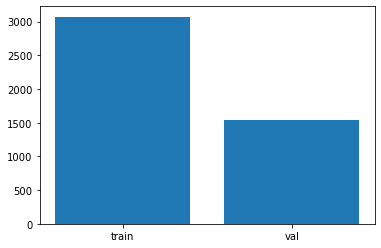

In [19]:
plt.bar(['train','val'],[len(os.listdir(DATASET_2D_BASE_PATH/'train'/'images')),len(os.listdir(DATASET_2D_BASE_PATH/'val'/'images'))])